In [21]:
# load in csv file
import csv
import numpy as np
import wave
import struct

x_trainAFile = [] # wave filename 
y_trainA = [] # label 

x_trainBFile = [] # wave filename 
y_trainB = [] # label 

# ignores all entries that are less than 2 seconds
def moreNsecs(file, N):
    f = wave.open(file)
    frames = f.readframes(-1)
    samples = struct.unpack('h'*f.getnframes(), frames)
    framerate = f.getframerate()
    t = [float(i)/framerate for i in range(len(samples))]
    if t[-1] > 2:
        return True
    else:
        return False

# ignores all entries without a label
with open('set_a.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if not row[2]=='' and not row[2]=='label': 
            if moreNsecs(row[1],2):
                x_trainAFile.append(row[1])
                y_trainA.append(row[2])
print(len(x_trainAFile))

with open('set_b.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if not row[2]=='' and not row[2]=='label': #and 'noisy' not in row[1]:
            fname = 'set_b/' + row[1][16:]
            new_fname = ''
            count = 0
            for c in fname:
                new_fname += c
                if c == '_' and 'noisy' not in row[1]:
                    if count == 1:
                       new_fname += '_' 
                    count += 1
            if moreNsecs(new_fname,2):
                x_trainBFile.append(new_fname)
                y_trainB.append(row[2])
print(len(x_trainBFile))

120
407


In [22]:
from pylab import *

def get_signal(file):
    f = wave.open(file)
    frames = f.readframes(-1)
    samples = struct.unpack('h'*f.getnframes(), frames)
    return samples

In [37]:
# dataset A, import sound files
x_trainA_raw = [] # features
for i in range(len(x_trainAFile)):
    x_trainA_raw.append(np.array(get_signal(x_trainAFile[i])))
x_trainA_raw = np.array(x_trainA_raw)
print(x_trainA_raw.shape)

# dataset B, import sound files
x_trainB_raw = [] # features
for i in range(len(x_trainBFile)):
    x_trainB_raw.append(np.array(get_signal(x_trainBFile[i])))
x_trainB_raw = np.array(x_trainB_raw)
print(x_trainB_raw.shape)

(120,)
(407,)


In [38]:
# downsample by a factor of 10
def down_sample(x, factor=10):
    r = range(len(x))
    down_array = []
    for i in r[0::factor]:
        down_array.append(x[i])
    return down_array

In [39]:
print(len(x_trainA_raw[0]))
x_trainA = []
x_trainA = np.array([down_sample(sample) for sample in x_trainA_raw])
print(len(x_trainA[0]))
print(x_trainA.shape)

396900
39690
(120,)


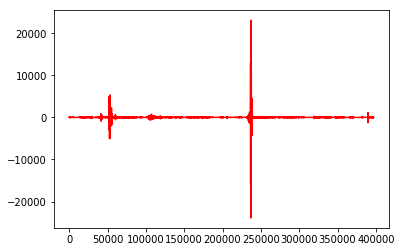

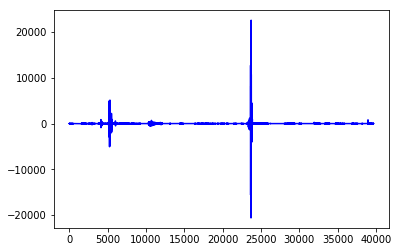

artifact


In [40]:
figure()
plot(x_trainA_raw[0],'r')
figure()
plot(x_trainA[0],'b')
show()
print(y_trainA[0])

In [27]:
# using wavelet decomposition
import pywt

In [41]:
# 4th-level Order Six Daubechies filter
x_trainA = np.array([pywt.dwt(x,'db4')[0] for x in x_trainA])
print(len(x_trainA[0]))
print(x_trainA.shape)

19848
(120,)


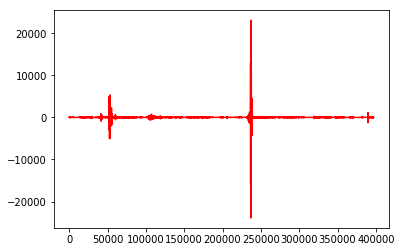

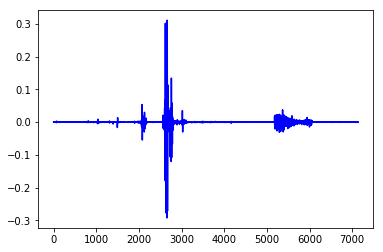

artifact


In [63]:
figure()
plot(x_trainA_raw[0],'r')
figure()
plot(x_trainA[0],'b')
show()
print(y_trainA[0])

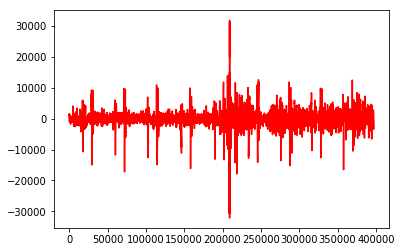

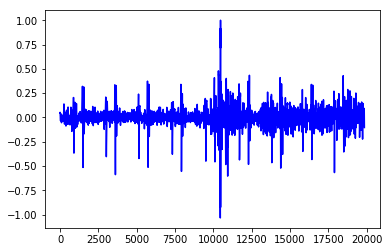

(120, 7138)


In [42]:
# normalize 
x_trainA = np.array([x/max(x) for x in x_trainA])

figure()
plot(x_trainA_raw[90],'r')
figure()
plot(x_trainA[90],'b')
show()

min_length = min(map(len, x_trainA))
x_trainA = np.array([x[:min_length] for x in x_trainA])
print(x_trainA.shape)

In [44]:
from scipy.signal import find_peaks_cwt
import numpy as np

def find_peaks(samples, set_name):
    if set_name.upper() == 'A':
        interval = 200
        r = 5
    else:
        interval = 20
        r = 2
    all_peaks = []
    for sample in samples:
        indexes = find_peaks_cwt(sample, np.arange(1, r))
        peaks = []
        for i in indexes:
            if sample[i] > 0.13:
                peaks.append(i)

        if len(peaks) > 1:
            i = 1
            start = 0
            tmp_array = []
            max_peak = sample[peaks[start]]
            max_ind = start
            while i < len(peaks):
                if peaks[i] <= (peaks[start] + interval):
                    if sample[peaks[i]] > max_peak:
                        max_peak = sample[peaks[i]]
                        max_ind = i
                    if i == len(peaks)-1:
                        tmp_array.append(peaks[max_ind])
                        break
                    i += 1
                else:
                    tmp_array.append(peaks[max_ind])
                    start = i 
                    max_ind = start
                    max_peak = sample[peaks[start]]
                    i += 1
            peaks = tmp_array
        all_peaks.append(peaks)
    return np.array(all_peaks)

all_peaks = find_peaks(x_trainA, 'A')

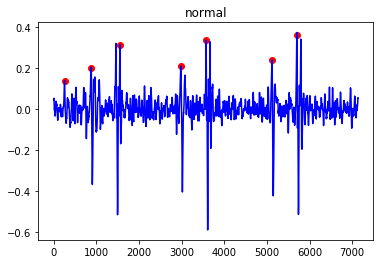

In [45]:
n = 90
figure()
title(y_trainA[n])
plot(x_trainA[n],'b')
scatter(all_peaks[n],x_trainA[n][all_peaks[n]],c='r')
show()

In [ ]:
# c = fft(x_trainA[45]) # calculate fourier transform (complex numbers list)
# plt.plot(c,'r') 
# plt.show()
# print(y_trainA[45])

# c = fft(x_trainA[60]) # calculate fourier transform (complex numbers list)
# plt.plot(c,'r') 
# plt.show()
# print(y_trainA[60])

# c = fft(x_trainA[102]) # calculate fourier transform (complex numbers list)
# plt.plot(c,'r') 
# plt.show()
# print(y_trainA[102])

# for i in range(len(x_trainA)):
#     c = fft(x_trainA[i])
#     plt.plot(c)
#     show()
#     print(y_trainA[i])

In [ ]:
# This is what the find_peaks function does
# Uncomment to see how the find_peaks works 
'''n = 90
from scipy.signal import find_peaks_cwt
indexes = find_peaks_cwt(x_trainA[n], np.arange(1, 5))
figure()
title(y_trainA[n])
plot(x_trainA[n],'b')
scatter(indexes,x_trainA[n][indexes],c='r')
show()

peaks = []
for x in x_trainA[n:n+1]:
    for i in indexes:
        if x[i] > 0.13:
            peaks.append(i)
figure()
plot(x_trainA[n],'b')
scatter(peaks,x_trainA[n][peaks],c='r')
show()

if len(peaks) > 1:
    i = 1
    start = 0
    tmp_array = []
    max_peak = x_trainA[n][peaks[start]]
    max_ind = start
    while i < len(peaks):
        if peaks[i] <= (peaks[start] + 200):
            if x_trainA[n][peaks[i]] > max_peak:
                max_peak = x_trainA[n][peaks[i]]
                max_ind = i
            if i == len(peaks)-1:
                tmp_array.append(peaks[max_ind])
                break
            i += 1
        else:
            tmp_array.append(peaks[max_ind])
            start = i 
            max_ind = start
            max_peak = x_trainA[n][peaks[start]]
            i += 1
    peaks = tmp_array

print(peaks)
figure()
plot(x_trainA[n],'b')
scatter(peaks,x_trainA[n][peaks],c='r')
show()'''

In [48]:
# features
# 1. number of peaks
# 2. average timing between peaks  
# 3. average strength of peaks 
# 4. min peak
# 5. max peak 
# would be also nice to find s1 and s2 and get m1 and m2 but don't even know what those are yet
# TO-DO: Learn more about extrahls and murmur and their differences from normal

def get_features(x_train,all_peaks):
    features = []
    for k in range(len(all_peaks)): 
        num_peaks = len(all_peaks[k])
        avg_between = 0
        avg_strength = 0
        if len(all_peaks[k]) == 1:
            avg_strength = x_train[k][all_peaks[k]]
        min_peak = 0
        max_peak = 0
        if num_peaks > 1:
            for i in range(1,len(all_peaks[k])):
                avg_between += np.abs(all_peaks[k][i] - all_peaks[k][i-1])
            avg_between /= len(all_peaks[k]) - 1
            min_peak = min(x_train[n][all_peaks[k]])
            max_peak = max(x_train[n][all_peaks[k]])
            for i in range(1,len(all_peaks[k])):
                avg_strength += x_train[n][all_peaks[k][i]]
            avg_strength /= len(all_peaks[k])
        features.append([num_peaks,avg_between,avg_strength,min_peak,max_peak])
    features = np.array(features)
    maxes = np.amax(features,axis=0)
    for feature in features:
        feature = np.array([feature[0]/maxes[0],feature[1]/maxes[1],feature[2]/maxes[2],feature[3]/maxes[3],feature[4]/maxes[4]])
    return features 

features = get_features(x_trainA,all_peaks)

In [161]:
#finding difference between all peaks in every file
all_diffs = []
for k in range(len(all_peaks)):
    diff = np.diff(all_peaks[k])
    all_diffs.append([diff])

#finding max difference or diastole period
# and then labelling the first peak as s2 and second peak as s1
max_index = []
s1s2_peaks = []
for k in range(len(all_diffs)):
    if any(all_diffs[k]):
        max_index.append(np.argmax(all_diffs[k]))
        s2 = all_peaks[k][max_index[k]]
        s1 = all_peaks[k][max_index[k]+1]
        s1s2_peaks.append([s1, s2])
    else:
        max_index.append([np.NaN])
        s1s2_peaks.append([np.NaN])

In [166]:
#defining s1 and s2 boundaries
s1_bounds = []
s2_bounds = []
upper_s1 = 200
lower_s1 = 80
upper_s2 = 600
lower_s2 = 70


for k in range(len(s1s2_peaks)):
    if np.isnan(s1s2_peaks[k][0]):
        s1_bounds.append(NaN)
        s2_bounds.append(NaN)
    else:
        s1_bounds.append([s1s2_peaks[k][0]-lower_s1, s1s2_peaks[k][0]+upper_s1])
        s2_bounds.append([s1s2_peaks[k][1]-lower_s1, s1s2_peaks[k][1]+upper_s1])


In [ ]:
#plotting s1 and s2
for k in range(len(all_peaks)):
    if np.isnan(s1s2_peaks[k][0]):
        print("No peaks were found.")
    else: 
        figure()
        title(y_trainA[k])
        plot(x_trainA[k],'b') #plots signal
        scatter(s1s2_peaks[k][0],x_trainA[k][s1s2_peaks[k][0]],c='r') #plots s1
        axvline(x=s1_bounds[k][0],c='r')
        axvline(x=s1_bounds[k][1],c='r')
        scatter(s1s2_peaks[k][1],x_trainA[k][s1s2_peaks[k][1]], c='y') #plots s2
        axvline(x=s2_bounds[k][0],c='y')
        axvline(x=s2_bounds[k][1],c='y')
        show()

In [211]:
#function for plotting class specific points of a feature
def featurePlot(feat):
    print("Red=artifacts, blue=extrahls, purple=murmur, cyan=normal")
    for i in range(len(feat)):
        if y_trainA[i] == 0:
            scatter(i,feat[i], c='r')
        elif y_trainA[i] == 1:
            scatter(i,feat[i], c='b')
        elif y_trainA[i] == 2:
            scatter(i,feat[i], c='m')
        elif y_trainA[i] == 3:
            scatter(i,feat[i], c='c')
    show()
    return

In [ ]:
#features from the naive bayes paper 
#power of s1 found using rms, waste
import audioop
power = []
for k in range(len(x_trainA)):
    if np.isnan(s1s2_peaks[k][0]):
        power.append([0])
    else:
        power.append([audioop.rms(x_trainA[k][s1_bounds[k][0]:s1_bounds[k][1]],1)])

featurePlot(power)

Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


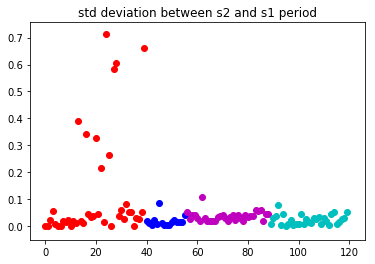

C:\Users\Shirley\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Shirley\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Shirley\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


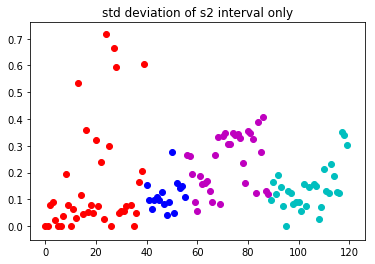

Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


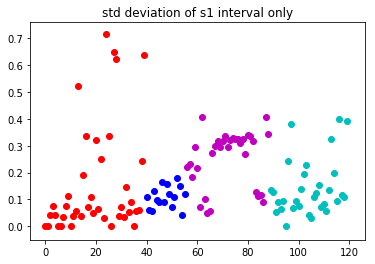

In [244]:
#time domain

# #mean value between s2 and s1 periods, waste
# mean = []
# for k in range(len(x_trainA)):
#     if np.isnan(s1s2_peaks[k][0]):
#         mean.append([0])
#     else:
#         signal = abs(x_trainA)
#         mean.append([(np.mean(signal[k][s2_bounds[k][1]:s1_bounds[k][0]]))*100])
# featurePlot(mean)

#std deviation of specific interval where
#lower is the left most bound of the interval, upper is right most bound
def stdInterval(lower,low_index,upper,up_index):
    std = []
    for k in range(len(x_trainA)):
        if np.isnan(s1s2_peaks[k][0]):
            std.append([0])
        else:
            std.append([np.std(x_trainA[k][lower[k][low_index]:upper[k][up_index]])])
    return std

title("std deviation between s2 and s1 period")
featurePlot(stdInterval(s2_bounds,1,s1_bounds,0))
title("std deviation of s2 interval only")
featurePlot(stdInterval(s2_bounds,0,s2_bounds,1))
title("std deviation of s1 interval only")
featurePlot(stdInterval(s1_bounds,0,s1_bounds,1))

In [135]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_trainA = le.fit_transform(y_trainA) # 0 - artifact, 1 - extrahls, 2 - murmur, 3 - normal

In [125]:
from sklearn import svm
from sklearn.model_selection import KFold

# split into train/test
# TO-DO: this is just my lazy way of splitting into train test, will do it properly with randomless later
kf = KFold(n_splits=5)
results = []
for tr, ts in kf.split(features):
    print("Performing training on fold...")
    clf = svm.SVC(C=70,probability=True, kernel='rbf')
    #clf.fit(x_trainA[tr], y_trainA[tr])
    results.append(clf.fit(features[tr], y_trainA[tr]).score(features[ts],y_trainA[ts]))
print(np.average(results))

Performing training on fold...
Performing training on fold...
Performing training on fold...
Performing training on fold...
Performing training on fold...
0.141666666667
